## Import Libraries

In [1]:
from quspin.operators import hamiltonian
from quspin.basis import spinless_fermion_basis_1d
import numpy as np
import matplotlib.pyplot as plt
import itertools
from quspin.tools.evolution import expm_multiply_parallel
from quspin.operators import quantum_LinearOperator
from quspin.operators import quantum_operator
plt.rcParams['figure.figsize'] = [10, 8]

## Define Constants/Helpers

In [2]:
N = 8
N_filled = N // 2
t = -0.5
g = -1
m = 1
PBC = True

T = 8
dt = 0.1

In [3]:
def stringbox(lst, caption):
    return caption + "-" * (100 - len(caption))+"\n" + str(lst) + "\n" + "-" * 100

## Fermion Basis

In [4]:
fermion_basis = spinless_fermion_basis_1d(L=N, Nf=N_filled)
fermion_basis_m1 = spinless_fermion_basis_1d(L=N, Nf=N_filled-1)
basis_full = spinless_fermion_basis_1d(L=N)

In [7]:
def E_squared(n):
    E_const = E_neg1 - (n + 1) // 2
    s_coupling = []
    d_coupling = []
    for i in range(n + 1):
        s_coeff = 2 * E_const * -g
        s_coupling += [[s_coeff, i, i]]
        for j in range(n + 1):
            d_coeff = -g
            d_coupling += [[d_coeff, i, i, j, j]]
    return [["+-", s_coupling], ["+-+-", d_coupling]]

def shortest_path(n, m, N):
    return np.min([np.abs(n - m), N - np.abs(n - m)])

def coupling(distance, N):
    if distance < 2:
        return distance
    elif distance == N // 2:
        return (N ** 2 - 8) / (4 * (N - 3))
    else:
        return distance + (distance ** 2 - 3 * distance + 1) / (3 - N)

def U1fermionH(g, t, m, N, N_filled, PBC, E_neg1=0, Hbasis=fermion_basis):
    P_neg1 = np.exp(-1j * E_neg1)
    static_terms = []
    dynamic_terms = []

    ### Hopping term
    L = (N if PBC else N-1)
    hop_coupling = [[-t, i, (i+1) % N] for i in range(L)]
    hop_coupling_dag = [[-t, (i+1) % N, i] for i in range(L)]
    static_terms += [["+-", hop_coupling]]
    static_terms += [["+-", hop_coupling_dag]]

    ### Mass term
    mass_coupling = [[m * (-1) ** i, i, i] for i in range(N)]
    static_terms += [["+-", mass_coupling]]

    ### E-field term
    if PBC:
        E_longrange_general = np.zeros((N,N))
        for n in range(N):
            for k in range(N):
                E_longrange_general[n,k] = coupling(shortest_path(n,k,N), N)
        E_longrange_general = -0.25 * (N - 3) / (N - 2) * E_longrange_general

        E_longrange = [[-0.5 * g * E_longrange_general[i,j],i,j] for i in range(N) for j in range(N)] # from gauss' law

        E_onsite_general = np.zeros(N)
        for n in range(N):
            for m in range(N):
                if (m%2==1):
                    E_onsite_general[n] += coupling(shortest_path(n, m, N), N) + coupling(shortest_path(m, n, N), N)

        E_onsite = [[0.5 * g * E_onsite_general[i],i] for i in range(N)]
        static_terms += [["nn",E_longrange],["n",E_onsite]]
    else:
        for i in range(L):
            static_terms += E_squared(i)

    return hamiltonian(static_terms, dynamic_terms, basis=Hbasis, dtype=np.float64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


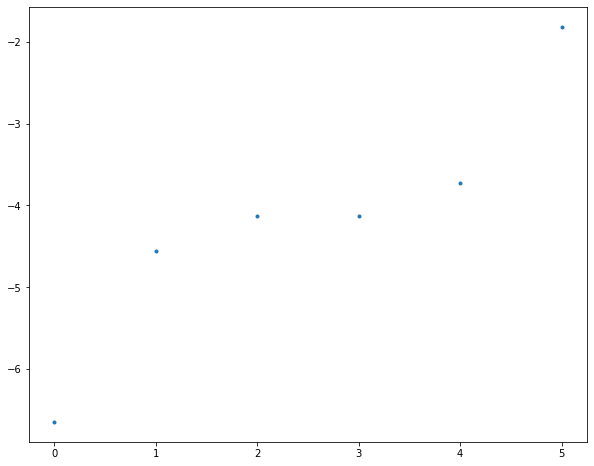

In [8]:
### Plotting spectrum
H = U1fermionH(g, t, m, N, N_filled, PBC)
fermion_eigvals = H.eigvalsh()
plt.plot(fermion_eigvals, ".")
plt.show()

## Real-time Dynamics

In [9]:
H_init = U1fermionH(g, t, m, N, N_filled, PBC)
H = U1fermionH(g, t, -m, N, N_filled, PBC)
E_init,V_init=H_init.eigsh(k=1,which='SA',maxiter=1e8)
psi_i = V_init[:,0]
psi_i = psi_i.reshape((-1,))
del H_init

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


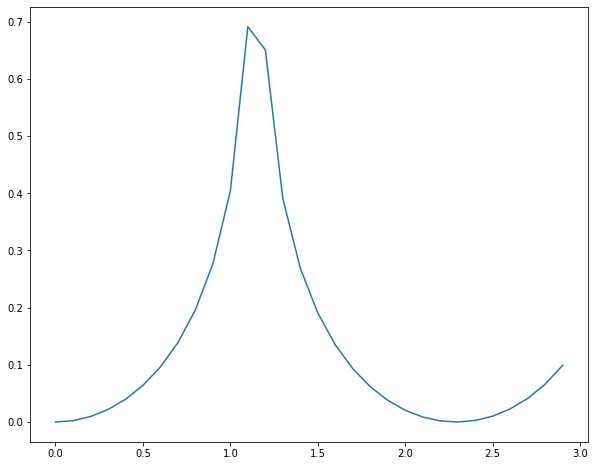

In [10]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times
Lt = np.zeros(len(times),dtype=dtype_real)              # Lohschmidt echo
# construct piece-wise constant unitaries
expH = expm_multiply_parallel(H.tocsr(),a=-1j*dt,dtype=dtype_cmplx)
# auxiliary array for memory efficiency
psi=psi_i.copy().astype(np.complex128)
work_array=np.zeros((2*len(psi),), dtype=psi.dtype) # twice as long because complex_valued
# prepare output
loschmidt = []
for i in range(len(times)):
#     if i % (len(times)//10) == 0:
#         print("# T = ",times[i])
    Lt[i]=-np.log(np.abs(np.vdot(psi_i,psi)))/N
#     print(f"{times[i]}\t {Lt[i]}")
    loschmidt += [Lt[i]]
    expH.dot(psi,work_array=work_array,overwrite_v=True)
# END of time evolution
plt.plot(times, loschmidt)

## Correlator calculation

In [11]:
def c_operator(n):
    cdag_static = [["-",[[1.0,n]]]]
    cdagn = quantum_LinearOperator(cdag_static,basis=basis_full,dtype=np.complex128,check_herm=False,check_pcon=False,check_symm=False)
    return(cdagn)
annihilators = [c_operator(n) for n in range(N)]

In [12]:
##### define data type for the simulation
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# pre assign arrays
times = np.arange(0,T,dt)                               # times

# array to store correlators expectations from psi(t,n) to psi(0,0)
correlators = np.zeros((N,len(times)),dtype=np.complex128)

P_Nhalf = fermion_basis.get_proj(dtype=np.float64)
P_Nhalfminus1 = fermion_basis_m1.get_proj(dtype=np.float64)

H_NHalf_m1 = U1fermionH(g, t, m, N, N_filled, PBC, Hbasis=fermion_basis_m1).tocsr()
H_NHalf = U1fermionH(g, t, m, N, N_filled, PBC, Hbasis=fermion_basis).tocsr()

for n in range(0, N, 2): #loop over all site pairings
    for i in range(len(times)): #loop over times (for annhilator location)
        # Even Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expmiH = expm_multiply_parallel(H_NHalf_m1,a=1j*dt*i,dtype=dtype_cmplx)
        expiH = expm_multiply_parallel(H_NHalf,a=-1j*dt*i,dtype=dtype_cmplx)

        expiH.dot(leftPsi,overwrite_v=True)
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[0].dot(P_Nhalf.dot(rightPsi)))

        correlators[n,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
        
        # Odd Correlators
        leftPsi=psi_i.copy().astype(np.complex128) #state for left-half of inner product
        rightPsi=psi_i.copy().astype(np.complex128) #state for right-half

        expiH.dot(leftPsi,overwrite_v=True) 
        tempLpsi = np.transpose(P_Nhalfminus1).dot(annihilators[n+1].dot(P_Nhalf.dot(leftPsi)))
        expmiH.dot(tempLpsi,overwrite_v=True)

        tempRpsi = np.transpose(P_Nhalfminus1).dot(annihilators[1].dot(P_Nhalf.dot(rightPsi)))

        correlators[n+1,i] = np.vdot(tempLpsi, tempRpsi) # (<a|b>) <0| . e^(-iHt) . psi\dagger_n . e^(iHt) . psi(0,0) . |0>
    
# correlators = correlators#/(len(times)/dt) # Averaging over N so that it is actually an expectation value
# END of time evolution

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


In [13]:
correlatorfft = []
for i in range(len(correlators[0, :])):
    fftsum = np.fft.fft(correlators[::2,i]) + np.fft.fft(correlators[1::2,i])
    correlatorfft.append(fftsum)
    
correlatorfft = np.array(correlatorfft)

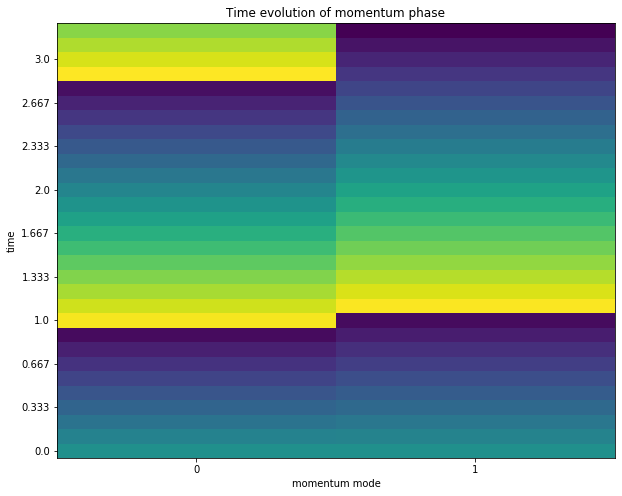

In [14]:
# plt.plot(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)))
plt.xlabel("momentum mode")
plt.ylabel("time")
plt.title("Time evolution of momentum phase")
step_x = 1 # step between consecutive labels
x_positions = np.arange(0,N//2,step_x) # pixel count at label position
x_labels = np.arange(N//4-N//2+1, N//4+1) # labels you want to see
plt.xticks(x_positions, x_labels)
y_tickcount = 10 # How many labels on y axis
y_positions = np.arange(0,int(T/dt), int((T/dt)/y_tickcount)) # pixel count at label position
y_labels = np.round(np.linspace(0,abs(T*m),y_tickcount), 3) # labels you want to see
plt.yticks(y_positions, y_labels)
plt.imshow(np.arctan2(np.imag(correlatorfft), np.real(correlatorfft)), aspect='auto', origin='lower')

## Topological Order Parameter Calculation

In [15]:
t_slices, k_modes = np.shape(correlatorfft)
dphi_k = np.zeros((t_slices-1, k_modes))
dphi_t = np.zeros((t_slices-1, k_modes))
for t in range(t_slices-1):
    for k in range(k_modes):
        dphi_k[t, k] = np.angle(correlatorfft[t, (k+1)%k_modes]/correlatorfft[t, k])
        dphi_t[t, k] = np.angle(correlatorfft[t + 1, k]/correlatorfft[t, k])
        
finite_full = np.zeros((t_slices - 2, k_modes))
for t in range(t_slices-2):
    for k in range(k_modes):
        finite_full[t, k] = (dphi_k[t, k] + dphi_t[t, (k+1)%k_modes]) - (dphi_k[t+1, k] + dphi_t[t, k])
finite_left = np.zeros(t_slices-2)
finite_right = np.zeros(t_slices-2)
for k in range(k_modes//2):
    finite_left += finite_full[:,k]/2/np.pi
    finite_right += finite_full[:,k+k_modes//2]/2/np.pi
n_left = []
n_right = []
for t in range(t_slices-2):
    ntau_left = 0
    ntau_right = 0
    for tau in range(0,t):
        ntau_left += finite_left[tau]
        ntau_right += finite_right[tau]
    n_left.append(ntau_left)
    n_right.append(ntau_right)
n_left = np.array(n_left)
n_right = np.array(n_right)

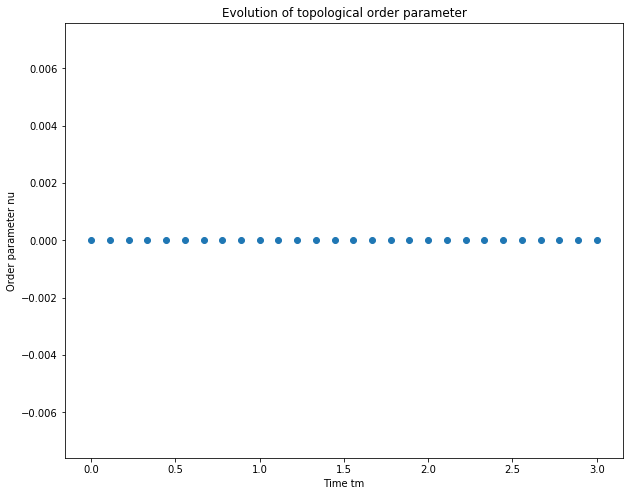

In [16]:
plt.scatter(np.linspace(0, T * m, len(n_left)), (n_left-n_right))
plt.xlabel("Time tm")
plt.ylabel("Order parameter nu")
plt.title("Evolution of topological order parameter")
plt.show()